## Installing torchfusion and importing other goodies


In [0]:
from torchfusion.gan.learners import *
from torchfusion.gan.applications import *
from torch.optim import Adam
from torchfusion.datasets import mnist_loader
import torch.cuda as cuda
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset
import torchvision.transforms as transforms
import torchvision
from torchvision.transforms import ToTensor
import pandas as pd
from PIL import Image, ImageEnhance 
from tqdm.notebook import tqdm
import numpy as np
from torch.utils.data import DataLoader
import torch
from numpy import moveaxis
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import cv2
from IPython.display import clear_output
import os
ROOT = "/content/drive/My Drive/kaggle/cars/"

In [27]:
!wget http://imagenet.stanford.edu/internal/car196/car_ims.tgz

--2020-05-01 15:06:03--  http://imagenet.stanford.edu/internal/car196/car_ims.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1956628579 (1.8G) [application/x-gzip]
Saving to: ‘car_ims.tgz’

car_ims.tgz         100%[===================>]   1.82G   749KB/s    in 15m 45s 

2020-05-01 15:21:48 (1.97 MB/s) - ‘car_ims.tgz’ saved [1956628579/1956628579]



In [0]:
!cp /content/car_ims.tgz /content/drive/"My Drive"/kaggle/cars/

In [0]:
!cp  /content/drive/"My Drive"/kaggle/cars/car_ims.tgz /content/

In [0]:
# make new dirs in runtime and unzip
!mkdir raw_images
!tar -zxvf /content/car_ims.tgz -C /content/raw_images

In [0]:
def img_to_arr(im_path):
    img = Image.open(im_path)
    x = np.array(img)
    if x.shape[-1] == 1 or len(x.shape) < 3:
        x = np.array([x,x,x])
        print(im_path, "was in grayscale, converted to RGB ")
    return x

class only_image_folder(Dataset):
    '''
    Build your own dataset
    '''
    def __init__(self, image_folder_path , transform = None):

        self.transform = transform

        print("Loading images from:  ", image_folder_path)

        self.label = []
        self.img = []

        for i in tqdm(os.listdir(image_folder_path)):
    
                filename = i
                full_path = image_folder_path + filename
                label_y = int(i[-8:-4])  ## remove the .jpeg ext and extract number 

                image_np_array = img_to_arr(full_path)

                self.label.append(label_y)
                self.img.append(image_np_array)

        self.label = np.array(self.label)
        self.img = np.array(self.img)

    def __getitem__(self, item):
        label, img = self.label[item], self.img[item]
        if self.transform is not None:
            img = self.transform(img)
        return img, torch.tensor([label])

    def __len__(self):
        return len(self.label)

In [0]:
# del train_set
train_set = only_image_folder("/content/raw_images/car_ims/",
              transform =transforms.Compose([          
                                                transforms.ToPILImage(),
                                                torchvision.transforms.RandomHorizontalFlip(p=0.5),
                                                torchvision.transforms.RandomAffine(degrees = 0, translate=(0.1, 0.1), scale=None, shear=None, resample=False, fillcolor=0),
                                                torchvision.transforms.Resize(size = (64, 64), interpolation=2),
                                                ToTensor()
                                           ])
              )

In [0]:
train_batch_size = 16
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle = True, num_workers = 2)

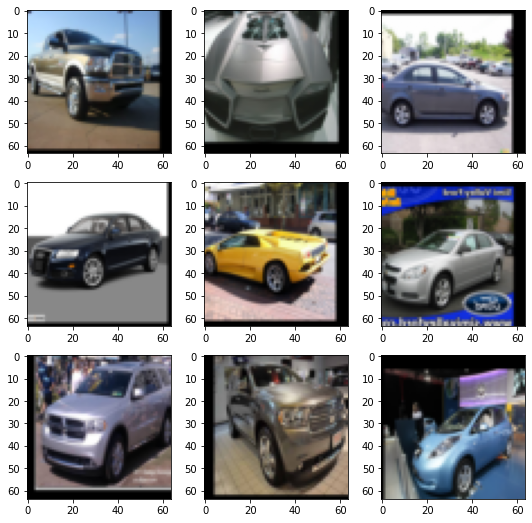

In [7]:
sample = next(iter(train_loader))
image_batch, labels = sample
m = 0
fig, ax = plt.subplots(3,3, figsize = (9,9))
for i in range (3):
    for j in range(3):
        image_np = image_batch[m].squeeze(0).numpy()
        image_mvaxis = moveaxis(image_np, 0,2)
        ax[i,j].imshow(image_mvaxis)
        m += 1

## Using the `StandardGenerator()` and the `StandardProjectionDiscriminator()` 

* `output_size = (color_channels, width, height )` - sets the dimensions of the output image. Set `color_channels = 3 ` for RGB images
* `latent_size` is the number of input channels which act as the "seed" for the generator.
* Make sure the output size of the generator is the same as the input size of the generator 

In [0]:
generated_image_size = (3, 64, 64)
latent_size =128
G = StandardGenerator(output_size= generated_image_size  ,latent_size= latent_size,  dropout_ratio = 0.3)
D = StandardProjectionDiscriminator(input_size=  generated_image_size ,apply_sigmoid=False)
# print(G)
# print(D)

## Defining the optimizers 

* increase `num_epochs` for better results
* A smaller latent size gave worse results.

In [0]:
torch.cuda.empty_cache()
if cuda.is_available():
    G = nn.DataParallel(G.cuda())
    D = nn.DataParallel(D.cuda())

# optimizers
g_optim = Adam(G.parameters(),lr=0.0003,betas=(0.5,0.999))
d_optim = Adam(D.parameters(),lr=0.0003,betas=(0.5,0.999))

g_optim_scheduler = ReduceLROnPlateau(g_optim, mode='min', factor=0.5, patience=5, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
learner = RStandardGanLearner(G,D)


Epoch 1 of 2


99/1012 batches : : 99it [00:30,  3.49it/s, Gen Loss=5.34, Disc Loss=0.116]

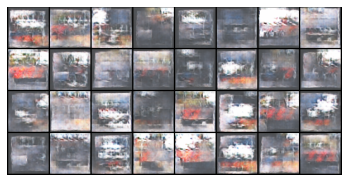

199/1012 batches : : 199it [00:59,  3.48it/s, Gen Loss=5.36, Disc Loss=0.089] 

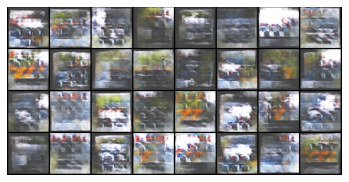

299/1012 batches : : 299it [01:28,  3.47it/s, Gen Loss=5.42, Disc Loss=0.0857]

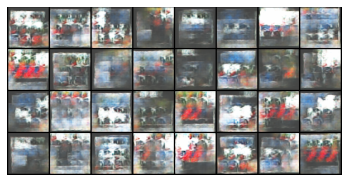

399/1012 batches : : 399it [01:57,  3.46it/s, Gen Loss=5.42, Disc Loss=0.0816]

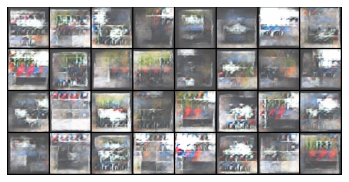

499/1012 batches : : 499it [02:26,  3.47it/s, Gen Loss=5.62, Disc Loss=0.0732]

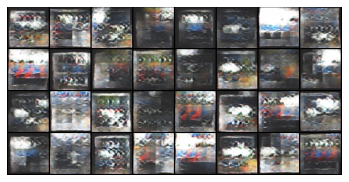

599/1012 batches : : 599it [02:55,  3.47it/s, Gen Loss=5.82, Disc Loss=0.0661]

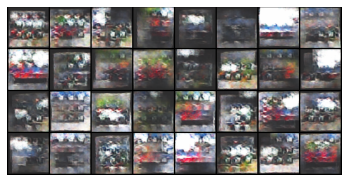

699/1012 batches : : 699it [03:24,  3.46it/s, Gen Loss=5.85, Disc Loss=0.0652]

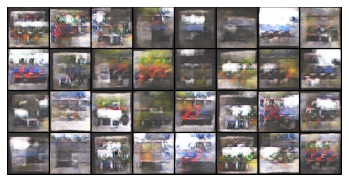

799/1012 batches : : 799it [03:53,  3.46it/s, Gen Loss=5.84, Disc Loss=0.0681]

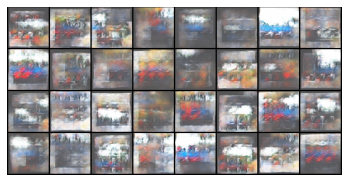

899/1012 batches : : 899it [04:22,  3.46it/s, Gen Loss=5.88, Disc Loss=0.0662]

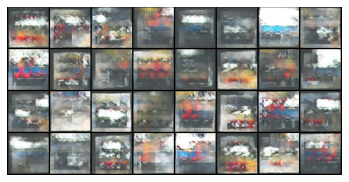

999/1012 batches : : 999it [04:51,  3.46it/s, Gen Loss=5.91, Disc Loss=0.0637]

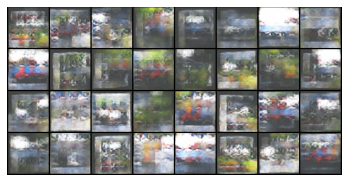

1012/1012 batches : : 1012it [04:56,  3.41it/s, Disc Loss=0.0633, Gen Loss=5.92]


New Generator model saved at ./car/gen_models/gen_model_1.pth
New Discriminator model saved at ./car/disc_models/disc_model_1.pth
Epoch: 1, Duration: 296.4416148662567 , Gen Loss: 5.92412389944393 Disc Loss: 0.06328952378021702


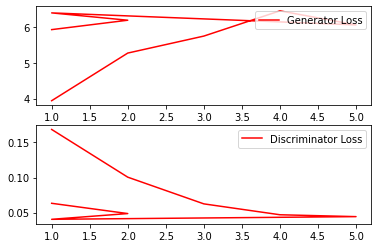

Epoch 2 of 2


87/1012 batches : : 87it [00:25,  3.48it/s, Gen Loss=6.16, Disc Loss=0.0576]

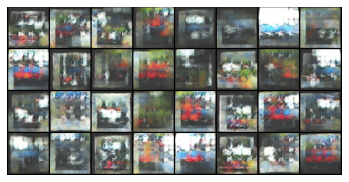

187/1012 batches : : 187it [00:54,  3.45it/s, Gen Loss=6.46, Disc Loss=0.0485]

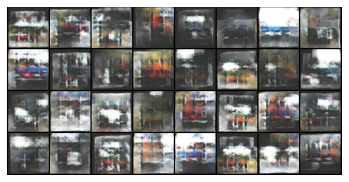

287/1012 batches : : 287it [01:23,  3.45it/s, Gen Loss=6.55, Disc Loss=0.0441]

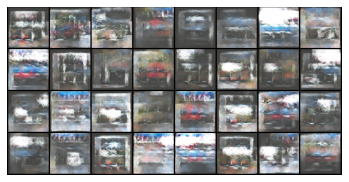

387/1012 batches : : 387it [01:52,  3.47it/s, Gen Loss=6.75, Disc Loss=0.0418]

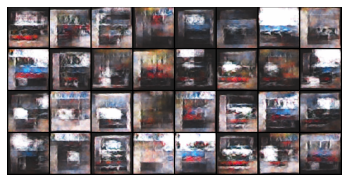

487/1012 batches : : 487it [02:21,  3.45it/s, Gen Loss=6.79, Disc Loss=0.0412]

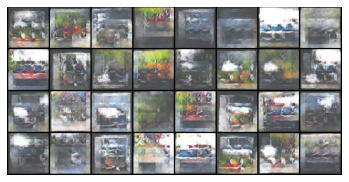

587/1012 batches : : 587it [02:50,  3.45it/s, Gen Loss=6.77, Disc Loss=0.0417]

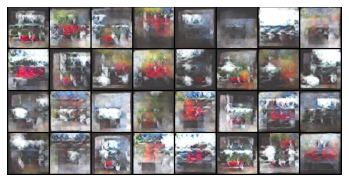

687/1012 batches : : 687it [03:19,  3.47it/s, Gen Loss=6.75, Disc Loss=0.0409]

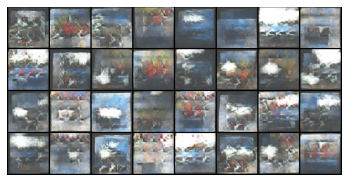

787/1012 batches : : 787it [03:49,  3.46it/s, Gen Loss=6.77, Disc Loss=0.0417]

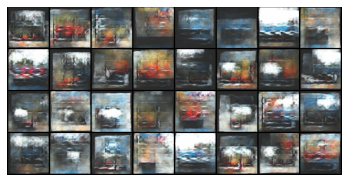

887/1012 batches : : 887it [04:18,  3.46it/s, Gen Loss=6.76, Disc Loss=0.0422]

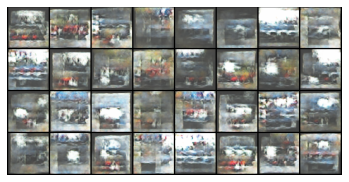

987/1012 batches : : 987it [04:47,  3.46it/s, Gen Loss=6.8, Disc Loss=0.0419]

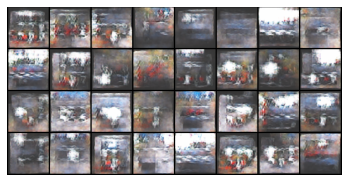

1012/1012 batches : : 1012it [04:54,  3.44it/s, Disc Loss=0.0424, Gen Loss=6.82]


New Generator model saved at ./car/gen_models/gen_model_2.pth
New Discriminator model saved at ./car/disc_models/disc_model_2.pth
Epoch: 2, Duration: 294.51803755760193 , Gen Loss: 6.816347119246216 Disc Loss: 0.04241293976989689


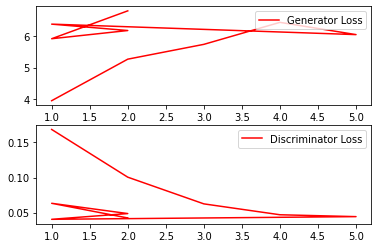

In [28]:
learner.train(
              train_loader,gen_optimizer=g_optim,disc_optimizer=d_optim,
              save_outputs_interval=100,
              model_dir="./car",
              latent_size= 128,
              num_epochs=2,
              batch_log=True,
              display_metrics = True,
              notebook_mode = False
              )

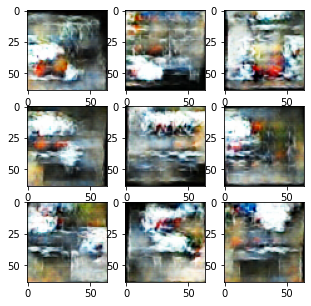

In [44]:
fig, ax = plt.subplots(3,3, figsize = (5,5))       
for i in range(3):
    for j in range(3):
        random_inp = torch.randn([1,128,1,1])
        output = G(random_inp)
        output = torch.clamp(output, min = 0, max = 255 , out=None)
        np_img = moveaxis(output.squeeze(0).detach().cpu().numpy(),0,2)
        # print(np_img.shape)
        # np_img = cv2.resize(np_img, (80,25))
        ax[i,j].imshow(np_img)

## Creating an interpolation with rolling values in the latent space 

In [0]:
random_inp = torch.randn([1,128,1,1])
images = []
p = 0
!rm -rf images
!mkdir images
for p in range(500):
    random_inp += 1
    random_inp = torch.roll(random_inp, p, dims = 1)
    output = G(random_inp)
    output = torch.clamp(output, min = 0, max = 255 , out=None)
    np_img = moveaxis(output.squeeze(0).detach().cpu().numpy(),0,2)
    clear_output(wait = True)
    # plt.imshow(np_img)
    # plt.show()
    plt.imsave( "images/" + str(p) + ".png", np_img)

In [64]:
names = [ "images/" + str(i) + ".png" for i in range (500)]
images = []
for n in names:
    frame = Image.open(n)
    images.append(frame)
print(len(images))

500


In [0]:
images[0].save('interpolation.gif',
               save_all=True,
               append_images=images[1:],
               duration=10,
               loop=0)